# Model Training Defect Detection
### Author: Cesar Castro M
### Date: 08/11/2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, f1_score, precision_score, recall_score

from sklearn.model_selection import cross_validate
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [2]:
# Read already prepared dataset
mfg_df = pd.read_csv('..\data\processed\predictive_maintenance_ready.csv')

In [3]:
# Replace [] on column names as some libraries have problems with these.
mfg_df.columns = mfg_df.columns.str.replace('[\[\]<>]', '', regex=True).astype(str)
mfg_df.columns = mfg_df.columns.str.replace(' ', '_').astype(str)

mfg_df.head()

,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Target,FailureType_encoded,Type_H,Type_L,Type_M
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0,1,False,False,True
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0,1,False,True,False
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0,1,False,True,False
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0,1,False,True,False
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0,1,False,True,False


In [4]:
# Separate target columns and features
X =mfg_df.drop(columns=['Target','FailureType_encoded'],axis=1)
y0 = mfg_df['Target']
y1 = mfg_df['FailureType_encoded']

# Split data for training and testing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y0, stratify=y0,  test_size=0.3, random_state=42)

In [6]:
#Data is highly imbalanced
print(f'Total fails: {y0.sum()} out of total data points {len(y0)}')

Total fails: 339 out of total data points 10000


Commonly manufacturing data for defects is very imbalanced as yields are typically high

# Model Training and Comparison

In [7]:
# Will Try Multiple Models based on some research
# Rerference: https://github.com/dataprofessor/code/blob/master/python/comparing-classifiers.ipynb


from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [8]:
names = ["Nearest_Neighbors",  "Gradient_Boosting", "Decision_Tree",
        "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
        "Naive_Bayes", "QDA",'LogisticRegression']

classifiers = [
    KNeighborsClassifier(3),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(random_state=42),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(random_state=42)
    ]

In [9]:
scores = []
metric = roc_auc_score
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    rscore = metric(y_test, y_prob)
    scores.append(rscore)

#https://github.com/dataprofessor/code/blob/master/python/comparing-classifiers.ipynb
df = pd.DataFrame()
df['name'] = names
df['ROC_AUC'] = scores
df

,name,ROC_AUC
0,Nearest_Neighbors,0.784725
1,Gradient_Boosting,0.820843
2,Decision_Tree,0.932831
3,Extra_Trees,0.906656
4,Random_Forest,0.972481
5,Neural_Net,0.917803
6,AdaBoost,0.899753
7,Naive_Bayes,0.827014
8,QDA,0.838547
9,LogisticRegression,0.880628


ROC AUC Scores are high for majority of the models evaluated

In [10]:
scores = []
metric = f1_score
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    rscore = metric(y_test, y_pred)
    scores.append(rscore)

#https://github.com/dataprofessor/code/blob/master/python/comparing-classifiers.ipynb
df = pd.DataFrame()
df['name'] = names
df['f1 score'] = scores
df

,name,f1 score
0,Nearest_Neighbors,0.423077
1,Gradient_Boosting,0.513966
2,Decision_Tree,0.503145
3,Extra_Trees,0.422535
4,Random_Forest,0.567742
5,Neural_Net,0.214876
6,AdaBoost,0.473373
7,Naive_Bayes,0.198758
8,QDA,0.278788
9,LogisticRegression,0.224000


F1 Score on the other side are not as high, indicating models can predict one class (the majority) but not great when predicting the target/fails.

# Hyperparemeter Tunning for Random Forest

Method #1: using GridSearchCV

In [11]:
from sklearn.model_selection import GridSearchCV

# Basic Model
rf = RandomForestClassifier(random_state=42)

# Random Parameters
param_grid = {
    'n_estimators': [50, 250, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 15, 30],
    'min_samples_leaf': [5, 10, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='f1',           # Focus on F1 score as trying to improve for the target 1 prediction.   
    n_jobs=-1,              
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation f1:", grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 250}
Best Cross-Validation f1: 0.635791532822667


Method #2: RandomizedSearchCV

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=5,scoring='f1')
rand_search.fit(X_train, y_train)
print('Best hyperparameters:', rand_search.best_params_)


Best hyperparameters: {'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 280}


Select using judment based on the results from 2 methods

In [13]:
def randomforest(X, y,X1, y1):
    
    model = RandomForestClassifier(n_estimators=50,
                                   max_depth=10,
                                   random_state=42,
                                   max_features='log2',
                                   min_samples_leaf=5,
                                   min_samples_split=5)

    #model = RandomForestClassifier(random_state=42)
    
    # Train the model
    model.fit(X, y)

    # Predictions
    y_pred = model.predict(X1)
    # Probabilities
    probabilities = model.predict_proba(X1)[:,1]

    # Use Probabilites for ROC AUC
    metric = roc_auc_score
    metric_name = "ROC AUC"
    auc_score = metric(y1, probabilities)
    print(f"RandomForestClassifier: {metric_name} on test dataset: {auc_score:.4f}")

    # Use predictions for F1 Score.
    metric = f1_score
    metric_name = "f1 score"
    precision_sc = metric(y1, y_pred)
    print(f"RandomForestClassifier: {metric_name} on test dataset: {precision_sc:.4f}")
    

    return model

In [14]:
# Model Training
rf_model = randomforest(X_train,y_train,X_test,y_test)


RandomForestClassifier: ROC AUC on test dataset: 0.9751
RandomForestClassifier: f1 score on test dataset: 0.6258


# Model Evaluation

In [15]:
#CrossValidation Function: will use to compare results between train and test data used during cross-validation to asses over-fitting.

def cross_validation_check(model,X,y):

    scoring = ['accuracy', 'precision','recall','f1', 'roc_auc']

    cv_results = cross_validate(model, X, y, cv=5, # 3-fold to make it faster
                          scoring=scoring,
                          return_train_score=True) 

    print(f"Cross validation results for Random Forest")
    for key in iter(cv_results):
        mean = cv_results[key].mean()
        print(f"{key} Cross Validation results {mean:.2f}")

    return cv_results

In [16]:
cv_results = cross_validation_check(rf_model,X,y0)


Cross validation results for Random Forest
fit_time Cross Validation results 0.30
score_time Cross Validation results 0.02
test_accuracy Cross Validation results 0.90
train_accuracy Cross Validation results 0.99
test_precision Cross Validation results 0.69
train_precision Cross Validation results 0.97
test_recall Cross Validation results 0.46
train_recall Cross Validation results 0.72
test_f1 Cross Validation results 0.45
train_f1 Cross Validation results 0.83
test_roc_auc Cross Validation results 0.90
train_roc_auc Cross Validation results 1.00


Model seems to be overfitting F1 score delta between train and test is high

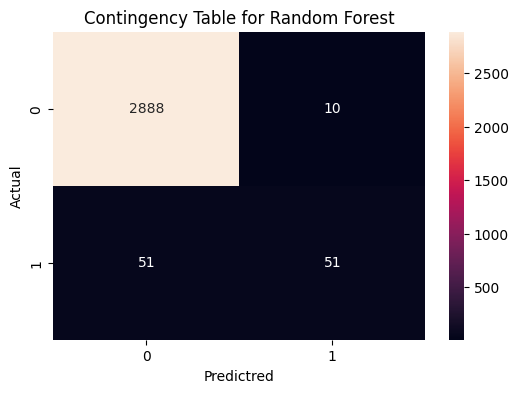

In [17]:
from sklearn.metrics import confusion_matrix

y_pred = rf_model.predict(X_test)

rm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(rm, annot=True, fmt='d')
plt.xlabel('Predictred')
plt.ylabel('Actual')
plt.title('Contingency Table for Random Forest')
plt.show()

Precision is very low, dataset is highly unbalanced, which is normal on manufacturing processes. 

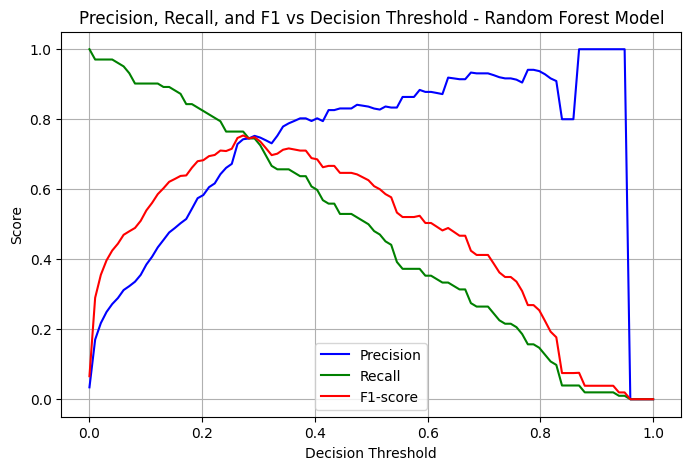

In [18]:
# Plot the precision, recall and F1 for different thresholds to define prediction

# Probabilities based on trained model
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate metrics for thresholds from 0 to 1
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], [] 

# check results for different thresholds.
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

# 6. Plot precision, recall, F1 vs threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', color='b')
plt.plot(thresholds, recalls, label='Recall', color='g')
plt.plot(thresholds, f1s, label='F1-score', color='r')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Decision Threshold - Random Forest Model')
plt.legend()
plt.grid(True)
plt.show()

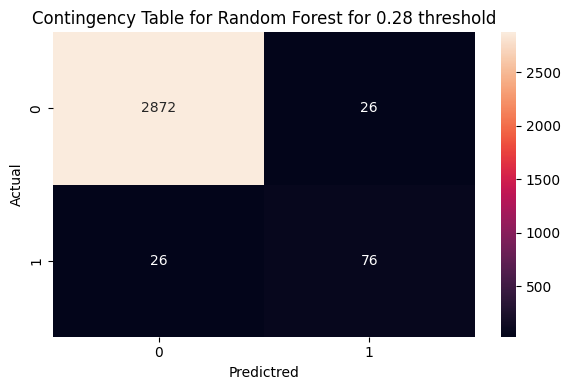

In [19]:
# Creating new predictions based on optimal threshold based on previuos chart

y_proba = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.28 #based on optmil F1 score
rf_preds_mod = (y_proba >= threshold).astype(int)

rm = confusion_matrix(y_test,rf_preds_mod)

plt.figure(figsize=(6,4))
sns.heatmap(rm, annot=True, fmt='d')
plt.xlabel('Predictred')
plt.ylabel('Actual')
plt.title('Contingency Table for Random Forest for 0.28 threshold')
plt.tight_layout()
plt.show()

In [20]:
# Function to plot features of importance for Random Forest Model 

def plot_feature_importances(importances, feature_names, model_type="Model"):
    
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(f'{model_type} - Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

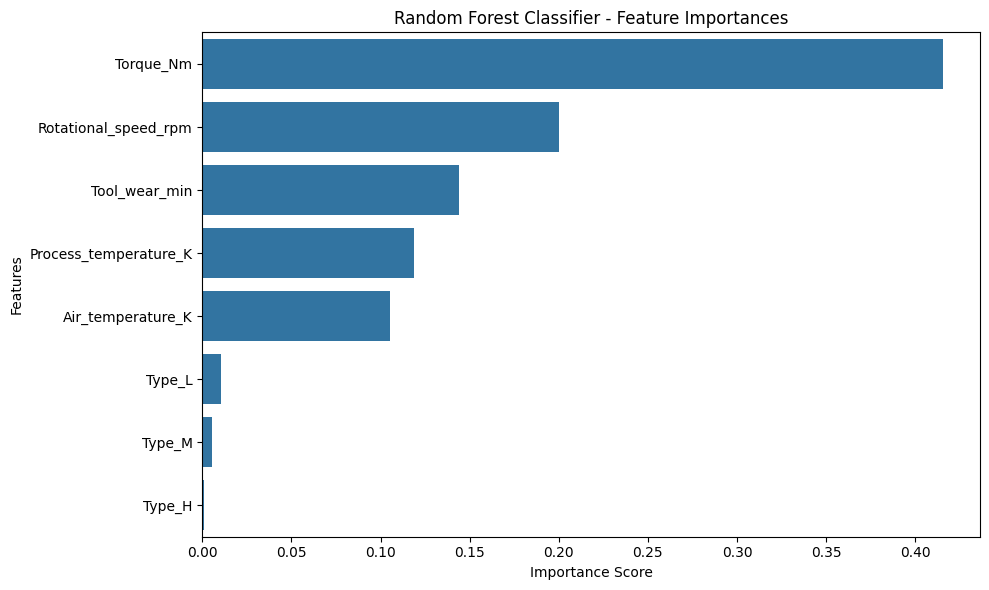

In [21]:
importances_rfm = rf_model.feature_importances_    
importance_df_rfm = plot_feature_importances(importances_rfm, X_train.columns.to_list(), "Random Forest Classifier")

# Handling imbalanced target

In [22]:
# Second Attemp using stratify sampling from train_test_split function
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y0, stratify=y0,  test_size=0.3, random_state=42)

In [23]:
rf_model_2 = randomforest(X_train2,y_train2,X_test2,y_test2)


RandomForestClassifier: ROC AUC on test dataset: 0.9751
RandomForestClassifier: f1 score on test dataset: 0.6258


Similar results compare to first RF model

In [24]:
# This attemp re-sampling
# Code Source: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# Synthetic Minority Oversampling Technique (SMOTE)


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

def randomforest_SMOTE(X, y,X1, y1):
    
    model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50,  # Same hyperparameters as before
                                   max_depth=10,
                                   random_state=42,
                                   max_features='log2',
                                   min_samples_leaf=5,
                                   min_samples_split=5))
                    ])

    # Train the model
    model.fit(X, y)

    y_pred = model.predict(X1)
    probabilities = model.predict_proba(X1)[:,1]

    metric = roc_auc_score
    metric_name = "ROC AUC"
    auc_score = metric(y1, probabilities)
    print(f"RandomForestClassifier: {metric_name} on test dataset: {auc_score:.4f}")

    metric = f1_score
    metric_name = "f1 score"
    precision_sc = metric(y1, y_pred)
    print(f"RandomForestClassifier: {metric_name} on test dataset: {precision_sc:.4f}")
    

    return model

In [25]:
rf_model_3 = randomforest_SMOTE(X_train2,y_train2,X_test2,y_test2)
results = cross_validation_check(rf_model_3,X,y0)

RandomForestClassifier: ROC AUC on test dataset: 0.9743
RandomForestClassifier: f1 score on test dataset: 0.5311
Cross validation results for Random Forest
fit_time Cross Validation results 0.84
score_time Cross Validation results 0.02
test_accuracy Cross Validation results 0.87
train_accuracy Cross Validation results 0.97
test_precision Cross Validation results 0.32
train_precision Cross Validation results 0.55
test_recall Cross Validation results 0.71
train_recall Cross Validation results 0.98
test_f1 Cross Validation results 0.40
train_f1 Cross Validation results 0.70
test_roc_auc Cross Validation results 0.92
train_roc_auc Cross Validation results 1.00


Worse Results when adding SMOTE - synthetic oversampling

In [26]:
# This attemp re-sampling
# Using Under Sampling

#Source: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
from imblearn.under_sampling import RandomUnderSampler

def randomforest_RuS(X, y,X1, y1):
    
    model = Pipeline([
    ('rus', RandomUnderSampler(random_state=42,sampling_strategy=0.3)),
    ('rf', RandomForestClassifier(random_state=42))
                    ])

    #model = RandomForestClassifier(random_state=42)
    
    # Train the model
    model.fit(X, y)

    y_pred = model.predict(X1)
    probabilities = model.predict_proba(X1)[:,1]

    metric = roc_auc_score
    metric_name = "ROC AUC"
    auc_score = metric(y1, probabilities)
    print(f"RandomForestClassifier: {metric_name} on test dataset: {auc_score:.4f}")

    metric = f1_score
    metric_name = "f1 score"
    precision_sc = metric(y1, y_pred)
    print(f"RandomForestClassifier: {metric_name} on test dataset: {precision_sc:.4f}")
    

    return model

In [27]:
rf_model_4 = randomforest_RuS(X_train2,y_train2,X_test2,y_test2)
results = cross_validation_check(rf_model_4,X,y0)

RandomForestClassifier: ROC AUC on test dataset: 0.9646
RandomForestClassifier: f1 score on test dataset: 0.5306
Cross validation results for Random Forest
fit_time Cross Validation results 0.14
score_time Cross Validation results 0.02
test_accuracy Cross Validation results 0.87
train_accuracy Cross Validation results 0.97
test_precision Cross Validation results 0.33
train_precision Cross Validation results 0.50
test_recall Cross Validation results 0.76
train_recall Cross Validation results 1.00
test_f1 Cross Validation results 0.42
train_f1 Cross Validation results 0.67
test_roc_auc Cross Validation results 0.92
train_roc_auc Cross Validation results 1.00


Not significant improvement with undersampling method

# Second Method - XGBOOST
Source: https://xgboosting.com/xgboost-for-imbalanced-classification/


In [28]:
import xgboost as xgb

scale_pos_weight = (len(y0) - np.sum(y0)) / np.sum(y0) #Intent is to give more weight to the minority class (1s on this case)

xgmodel = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgmodel.fit(X_train, y_train)
y_pred = xgmodel.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.3f}")

F1 Score: 0.757


In [29]:
results = cross_validation_check(xgmodel,X_train,y_train)

Cross validation results for Random Forest
fit_time Cross Validation results 0.12
score_time Cross Validation results 0.01
test_accuracy Cross Validation results 0.98
train_accuracy Cross Validation results 1.00
test_precision Cross Validation results 0.74
train_precision Cross Validation results 1.00
test_recall Cross Validation results 0.72
train_recall Cross Validation results 1.00
test_f1 Cross Validation results 0.73
train_f1 Cross Validation results 1.00
test_roc_auc Cross Validation results 0.97
train_roc_auc Cross Validation results 1.00


Better results than Random Forest. Still there is some over-fitting on the model but less than RF


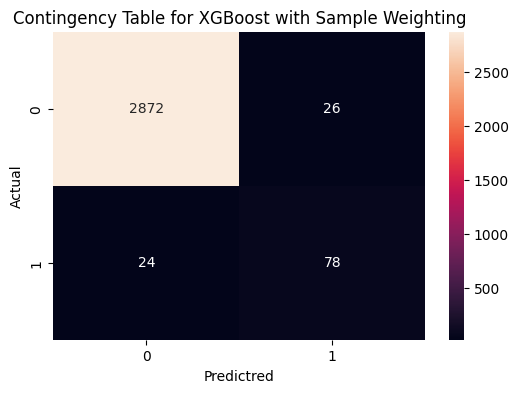

In [30]:
# Contingency Table
y_pred = xgmodel.predict(X_test)

rm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(rm, annot=True, fmt='d')
plt.xlabel('Predictred')
plt.ylabel('Actual')
plt.title('Contingency Table for XGBoost with Sample Weighting')
plt.show()

Testing if can improve model with hyperparameter tuning

In [31]:
# Same method as with Random Forest
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 300),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

rand_search = RandomizedSearchCV(xgmodel, param_distributions=param_dist, n_iter=20, cv=5,scoring='f1')
rand_search.fit(X_train, y_train)
print('Best hyperparameters:', rand_search.best_params_)


Best hyperparameters: {'colsample_bytree': np.float64(0.8426068608991865), 'learning_rate': np.float64(0.2589806507914076), 'max_depth': 5, 'n_estimators': 216, 'subsample': np.float64(0.9010342428678821)}


In [32]:
xgmodel2 = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    colsample_bytree=0.935,
    learning_rate=0.134,
    max_depth=8,
    n_estimators=240,
    subsample=0.8
)

xgmodel2.fit(X_train, y_train)
y_pred = xgmodel.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.3f}")

F1 Score: 0.757


Inital XGBoost model performed better

In [33]:
results = cross_validation_check(xgmodel2,X_train,y_train)

Cross validation results for Random Forest
fit_time Cross Validation results 0.25
score_time Cross Validation results 0.02
test_accuracy Cross Validation results 0.98
train_accuracy Cross Validation results 1.00
test_precision Cross Validation results 0.76
train_precision Cross Validation results 1.00
test_recall Cross Validation results 0.71
train_recall Cross Validation results 1.00
test_f1 Cross Validation results 0.73
train_f1 Cross Validation results 1.00
test_roc_auc Cross Validation results 0.97
train_roc_auc Cross Validation results 1.00


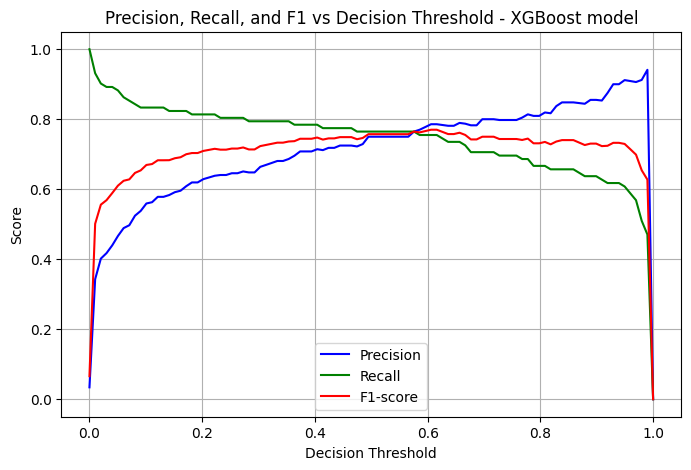

In [34]:
# Plot the precision, recall and F1 for different thresholds to define prediction

# Probabilities based on trained model
y_proba = xgmodel.predict_proba(X_test)[:, 1]

# Evaluate metrics for thresholds from 0 to 1
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], [] 

# check results for different thresholds.
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

# 6. Plot precision, recall, F1 vs threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', color='b')
plt.plot(thresholds, recalls, label='Recall', color='g')
plt.plot(thresholds, f1s, label='F1-score', color='r')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Decision Threshold - XGBoost model')
plt.legend()
plt.grid(True)
plt.show()

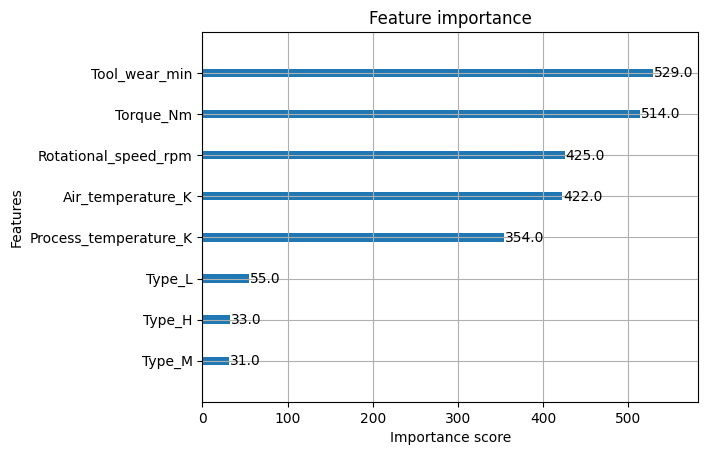

In [35]:
from xgboost import plot_importance

plot_importance(xgmodel, importance_type='weight')
plt.show()

# FAILURE TYPE PREDICTION

In [36]:
X_trainF, X_testF, y_trainF, y_testF = train_test_split(X, y1,  test_size=0.3, random_state=42)

In [37]:
def randomforest_m(X, y,X1, y1):
    
    model = RandomForestClassifier(n_estimators=50,
                                   max_depth=10,
                                   random_state=42,
                                   max_features='log2',
                                   min_samples_leaf=5,
                                   min_samples_split=5)

    #model = RandomForestClassifier(random_state=42)
    
    # Train the model
    model.fit(X, y)

    y_pred = model.predict(X1)
    probabilities = model.predict_proba(X1)

    metric_name = "ROC AUC"
    auc_score = roc_auc_score(y1, probabilities, multi_class='ovr')
    print(f"RandomForestClassifier: {metric_name} on test dataset: {auc_score:.4f}")

    f1_macro = f1_score(y1, y_pred, average='macro')
    f1_micro = f1_score(y1, y_pred, average='micro')
    print(f"RandomForestClassifier: F1 Macro on test dataset: {f1_macro:.4f}")
    print(f"RandomForestClassifier: F1 Micro on test dataset: {f1_micro:.4f}")
    
    f1_per_class = f1_score(y1, y_pred, average=None)

    print("F1 score per class:", f1_per_class)

    return model

In [38]:
rfm_model = randomforest_m(X_trainF,y_trainF,X_testF,y_testF)

RandomForestClassifier: ROC AUC on test dataset: 0.9009
RandomForestClassifier: F1 Macro on test dataset: 0.4965
RandomForestClassifier: F1 Micro on test dataset: 0.9800
F1 score per class: [0.68421053 0.9897506  0.53333333 0.77192982 0.         0.        ]


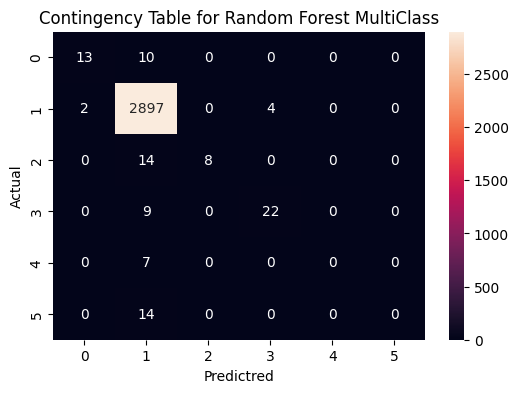

In [39]:
y_pred_m = rfm_model.predict(X_testF)
rm = confusion_matrix(y_testF,y_pred_m)

plt.figure(figsize=(6,4))
sns.heatmap(rm, annot=True, fmt='d')
plt.xlabel('Predictred')
plt.ylabel('Actual')
plt.title('Contingency Table for Random Forest MultiClass')
plt.show()


Class Names: 'Heat Dissipation Failure': 0, 'No Failure': 1, 'Overstrain Failure': 2, 'Power Failure': 3, 'Random Failures': 4, 'Tool Wear Failure': 5

In [40]:
classes, counts = np.unique(y_train, return_counts=True)
inv_freq = 1.0 / counts
class_weights = dict(zip(classes, inv_freq))
sample_weights = np.array([class_weights[label] for label in y_train])

xgmodelm = xgb.XGBClassifier(
    sample_weight=sample_weights,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgmodelm.fit(X_trainF, y_trainF)
y_pred = xgmodelm.predict(X_testF)

f1_per_class = f1_score(y_testF, y_pred, average=None)

print("F1 score per class:", f1_per_class)

F1 score per class: [0.95652174 0.9936546  0.76190476 0.8        0.         0.        ]


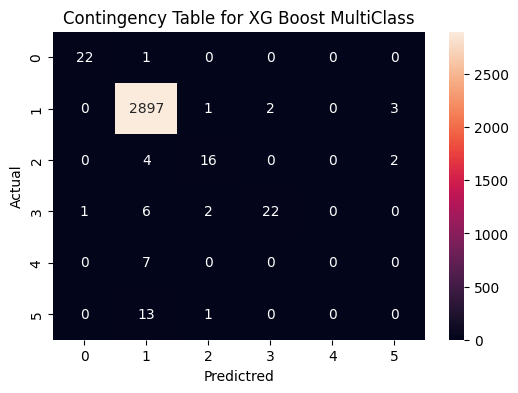

In [41]:
rm = confusion_matrix(y_testF,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(rm, annot=True, fmt='d')
plt.xlabel('Predictred')
plt.ylabel('Actual')
plt.title('Contingency Table for XG Boost MultiClass')
plt.show()

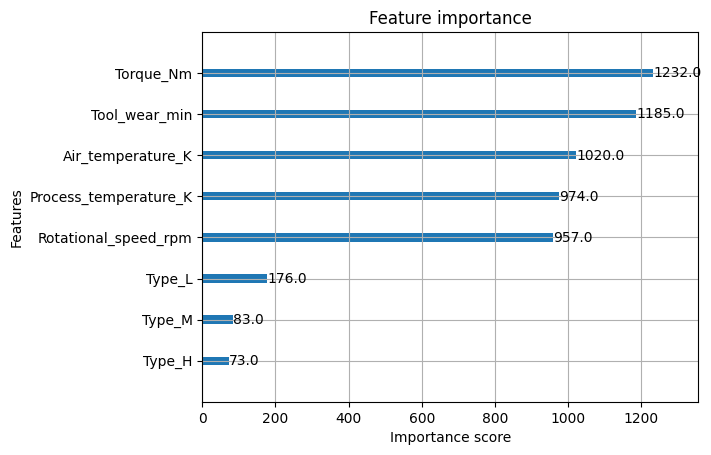

In [42]:
from xgboost import plot_importance

plot_importance(xgmodelm, importance_type='weight')
plt.show()

# Clustering

In [66]:
# Will use only numeric columns for clustering
num_cols = X.select_dtypes(include="number").columns.to_list()
X_cl = X[num_cols]


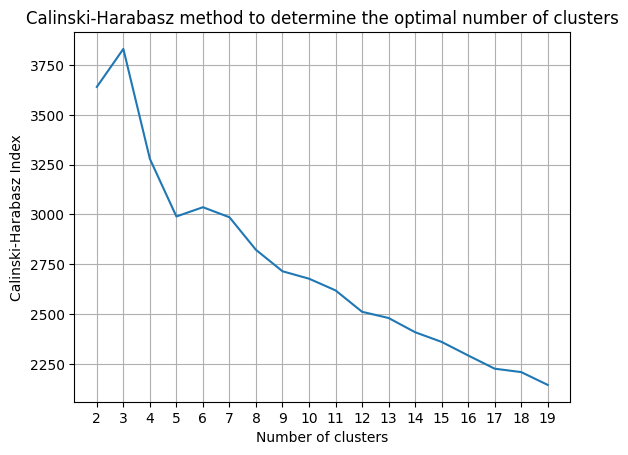

In [67]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
from matplotlib.ticker import MultipleLocator


#source: https://towardsdatascience.com/calinski-harabasz-index-for-k-means-clustering-evaluation-using-python-4fefeeb2988e/
results = {}

for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(X_cl)
    db_index = calinski_harabasz_score(X_cl, labels)
    results.update({i: db_index})

fig, ax = plt.subplots()

ax.plot(list(results.keys()), list(results.values()))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.grid(True)
ax.set_title('Calinski-Harabasz method to determine the optimal number of clusters')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Calinski-Harabasz Index")

plt.show()

In [68]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_cl)
kmeans_labels = labels

<Figure size 1000x600 with 0 Axes>

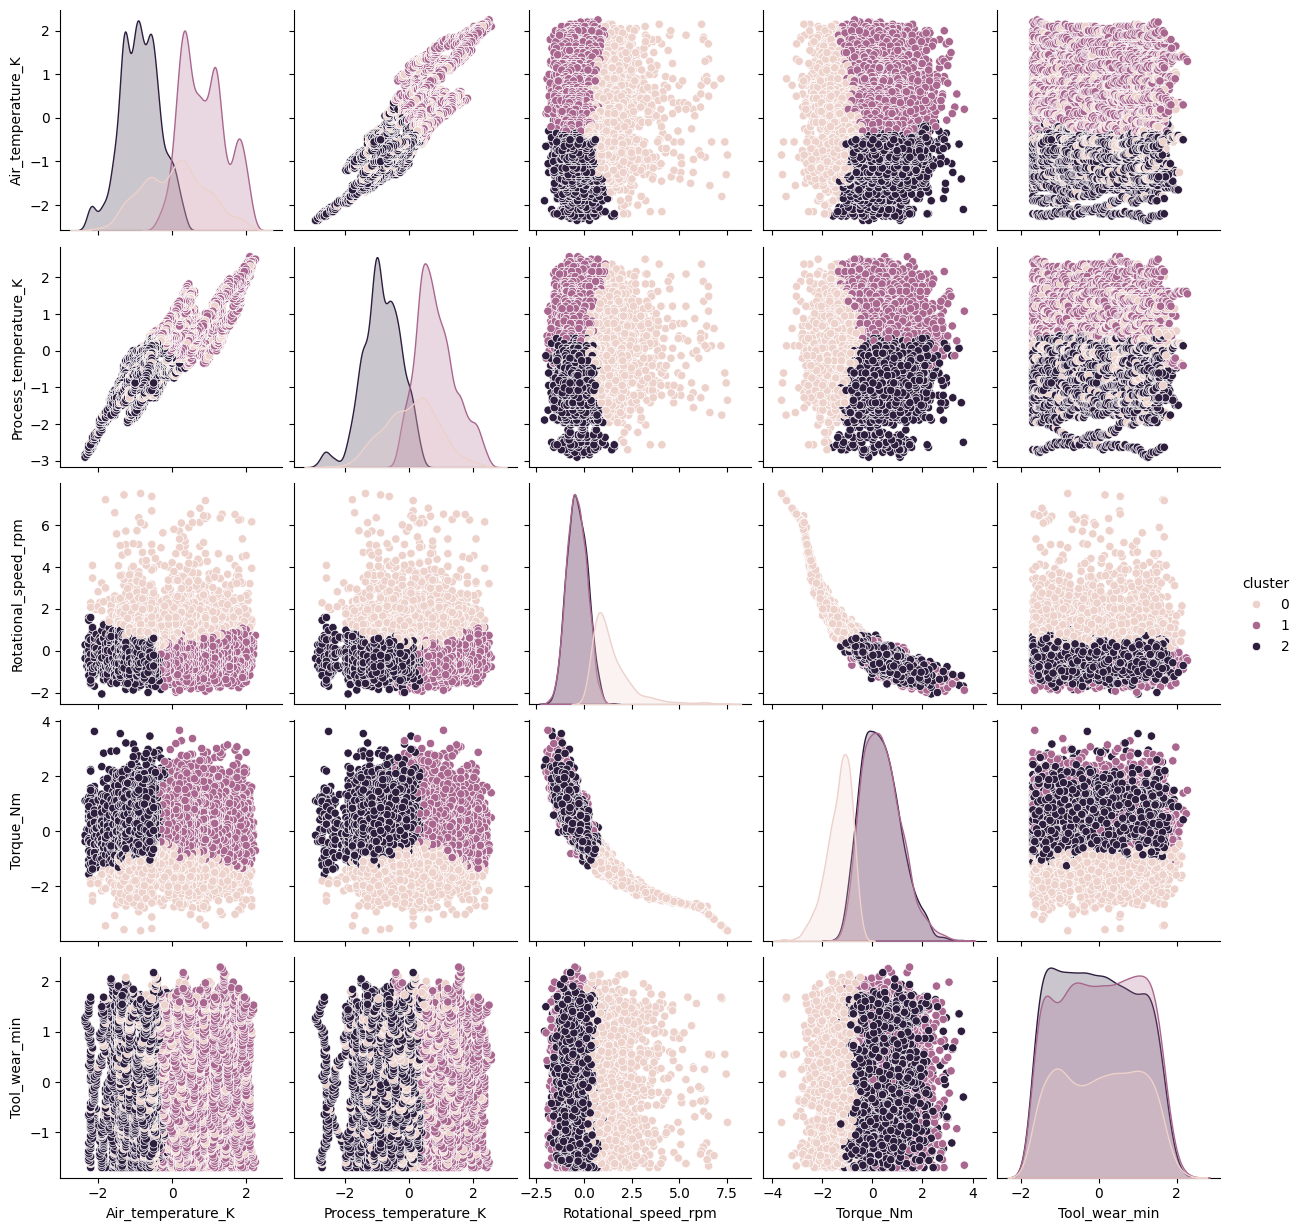

In [69]:
plt_df = X_cl.copy()
plt_df['cluster'] = kmeans_labels
plt.figure(figsize=(10,6))
sns.pairplot(plt_df, diag_kind='kde', hue='cluster')
plt.show()

In [73]:
# Create new feature calculating the distance to the center of the cluster
all_distances = kmeans.transform(X_cl)
assigned_distances = all_distances[np.arange(len(X_cl)), labels]
X['dist_cluster_center'] = assigned_distances
X.head()


,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Type_H,Type_L,Type_M,dist_cluster_center
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,False,False,True,1.707273
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,False,True,False,1.671828
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,False,True,False,1.700837
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,False,True,False,1.602883
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,False,True,False,1.585680


In [79]:
X_traink, X_testk, y_traink, y_testk = train_test_split(X, y0, stratify=y0,  test_size=0.3, random_state=42)


In [ ]:
scale_pos_weight = (len(y0) - np.sum(y0)) / np.sum(y0) #Intent is to give more weight to the minority class (1s on this case)

xgmodel_k = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgmodel_k.fit(X_traink, y_traink)
y_pred_k = xgmodel_k.predict(X_testk)

f1 = f1_score(y_testk, y_pred_k)
print(f"F1 Score: {f1:.3f}")

F1 Score: 0.745
